In [1]:
import os
import time
import heapq
import math
import numpy as np
import matplotlib.pyplot as plt
from math import log10, floor, sqrt
from itertools import combinations
from numpy import ceil, loadtxt, linalg, inner, matmul, zeros, log10, floor, array, dot, set_printoptions
from gurobipy import GRB, Model, quicksum
from matplotlib.ticker import FormatStrFormatter
from matplotlib import cm
from prody import *
from Bio.SVDSuperimposer import SVDSuperimposer 

try:
    from gurobipy import GRB, Model, quicksum
    HAS_GUROBI = True
except ImportError:
    HAS_GUROBI = False
    print("Gurobi not found. Optimization functions will need to be skipped.") 

def round_sig(x, sig=2):
    if x == 0: return 0
    return round(x, sig-int(floor(log10(abs(x))))-1)

### Configuration Parameters
Define the input files and optimization range:
- **INITIAL_PDB / FINAL_PDB**: Paths to your starting and target structures.
- **INITIAL_DCD**: Path to your trajectory file (required for DCD Analysis).
- **Kmin / Kmax**: The minimum and maximum number of perturbation residues to solve for.

In [2]:
FINAL_PDB = "final.pdb"
INITIAL_PDB = "initial.pdb"
INITIAL_DCD = "initial.dcd"

Kmin = 1
Kmax = 3

### Superposition Helper
Function to superimpose two structures using SVDSuperimposer

In [3]:
def superposer(value_x, value_y):
    x = np.array(value_x , "f")
    y = np.array(value_y, "f")
    superpose = SVDSuperimposer()
    superpose.set(x, y)
    superpose.run()
    rms = superpose.get_rms()
    rot, tran = superpose.get_rotran()
    initial_on_final = np.dot(y, rot) + tran
    return initial_on_final, rms

# Protocol Selection

Please choose the analysis section based on your available input files:

- **Option 1: Static Structures (PDB Analysis)**
  - Use this if you have `final.pdb` and `initial.pdb`.
  - Calculates displacement vectors and Hessian from static structures.

- **Option 2: MD Trajectory (DCD Analysis)**
  - Use this if you have the trajectory file (e.g. `initial.dcd`) and topology.


## Option 1: PDB Only Analysis

> **Requirements**: `final.pdb`, `initial.pdb`

### Displacement Vector Calculation


In [4]:
pdb = parsePDB(FINAL_PDB)
structure_calpha = pdb.select("calpha")
initial = parsePDB(INITIAL_PDB).select("calpha").getCoords()
final = parsePDB(FINAL_PDB).select("calpha").getCoords()
residue_number = len(structure_calpha)
final_alg = superposer(initial, final)
diffE = (final_alg[0]-initial).reshape(residue_number*3, 1)
np.savetxt("diffE.dat", diffE)
rms = final_alg[1]

@> 33632 atoms and 1 coordinate set(s) were parsed in 0.12s.
@> 32955 atoms and 1 coordinate set(s) were parsed in 0.11s.
@> 33632 atoms and 1 coordinate set(s) were parsed in 0.12s.


### Hessian Calculation


In [5]:
initial_anm = ANM('')
initial_anm.buildHessian(initial, cutoff=12, gamma=1)
initial_hes = initial_anm.getHessian()
print(initial_anm.getEigvals())
initial_inv_hes = np.linalg.pinv(initial_hes)
np.savetxt("initial_hessian.dat", initial_hes)
np.savetxt("initial_inv_hessian.dat", initial_inv_hes)

@> Hessian was built in 0.03s.
/opt/anaconda3/envs/prody_env/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/opt/anaconda3/envs/prody_env/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/opt/anaconda3/envs/prody_env/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


None


## Option 2: Trajectory Analysis (DCD)

> **Requirements**: `final.pdb`, `initial.pdb`, `initial.dcd`

### Fetch Initial Structure and Iterative Superposition

In [6]:
if os.path.exists("initial.dcd"):
    pdb = parsePDB("initial.pdb")
    ensemble_cov_2 = parseDCD("initial.dcd")
    structure_calpha = pdb.select("calpha")
    residue_number = len(structure_calpha)
    ensemble_length = len(ensemble_cov_2)
    ensemble_cov_2_mean_ref = (ensemble_cov_2.getCoordsets()).mean(0)
    ensemble_cov_2.setAtoms(structure_calpha)
    ensemble_cov_2_mean = (ensemble_cov_2.getCoordsets()).mean(0)
    ensemble_cov_2.setCoords(ensemble_cov_2_mean_ref)
    ensemble_cov_2.iterpose(rmsd=0.00001)
else:
    print("initial.dcd not found. Skipping DCD analysis (Option 2).")

@> 32955 atoms and 1 coordinate set(s) were parsed in 0.11s.
@> DCD file contains 2001 coordinate sets for 32955 atoms.
@> DCD file was parsed in 0.30 seconds.
@> 754.81 MB parsed at input rate 2549.46 MB/s.
@> 2001 coordinate sets parsed at input rate 6758 frame/s.
@> Starting iterative superposition:
@> Step #1: RMSD difference = 4.1819e+00
@> Superposing  [ 47%] 1sIOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

@> Step #2: RMSD difference = 9.8633e-04
@> Step #3: RMSD difference = 6.1732e-06
@> Iterative superposition completed in 1.78s.


### RMSD Plot


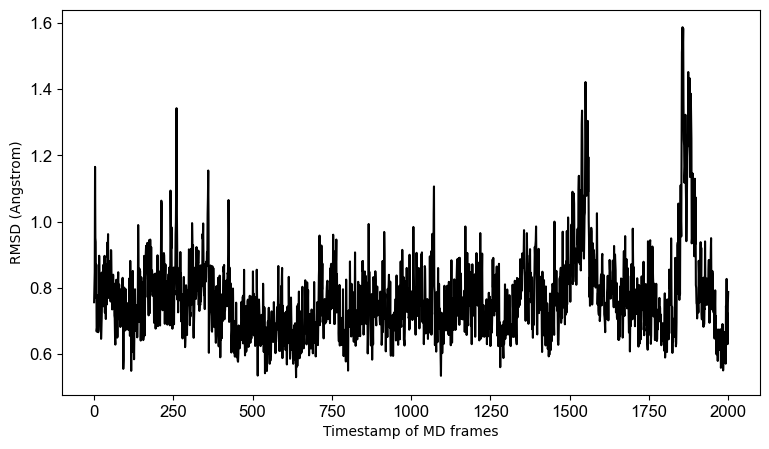

In [7]:
if 'ensemble_cov_2' in locals():
    RMSD = ensemble_cov_2.getRMSDs()
    fig, ax = plt.subplots(figsize=(9,5))
    ax.set_ylabel('RMSD (Angstrom)'); #set label names
    ax.set_xlabel('Timestamp of MD frames');
    plt.yticks(fontsize=12, fontname = "Arial")
    plt.xticks(fontsize=12, fontname = "Arial")
    plt.plot(RMSD, color="black")
    plt.show()
    plt.close()
    np.savetxt("rmsd_initial.dat", RMSD)

else:
    print("Skipping RMSD plot (No DCD loaded).")

### Displacement Vector Calculation


In [8]:
if 'ensemble_cov_2' in locals():
    R_mat = np.zeros((ensemble_length, residue_number, 3))
    ensemble_cov_2_coors = (ensemble_cov_2.getCoordsets())
    ensemble_cov_2_coors.shape
    ensemble_cov_2_mean.shape

    for i in range(ensemble_length):
        R_mat[i, :, :] = ensemble_cov_2_coors[i, :, :] - ensemble_cov_2_mean

    R_mat[0, 0, :]
    f_mat = R_mat.reshape(ensemble_length, residue_number*3).T
    s_mat = R_mat.reshape(ensemble_length, residue_number*3)
else:
    print("Skipping Displacement Vector calculation (No DCD loaded).")

### Covariance Matrix


In [9]:
if 'f_mat' in locals() and 's_mat' in locals():
    cov_mat = np.divide(np.matmul(f_mat,s_mat), ensemble_length-1)
else:
    print("Skipping Covariance Matrix calculation (No DCD data).")

/var/folders/t2/3k7jg41d3971xn4gxyv_vl4m0000gn/T/ipykernel_6212/4174513127.py:2: RuntimeWarning: divide by zero encountered in matmul
  cov_mat = np.divide(np.matmul(f_mat,s_mat), ensemble_length-1)
/var/folders/t2/3k7jg41d3971xn4gxyv_vl4m0000gn/T/ipykernel_6212/4174513127.py:2: RuntimeWarning: overflow encountered in matmul
  cov_mat = np.divide(np.matmul(f_mat,s_mat), ensemble_length-1)
/var/folders/t2/3k7jg41d3971xn4gxyv_vl4m0000gn/T/ipykernel_6212/4174513127.py:2: RuntimeWarning: invalid value encountered in matmul
  cov_mat = np.divide(np.matmul(f_mat,s_mat), ensemble_length-1)


In [10]:
if 'cov_mat' in locals():
    initial = structure_calpha.getCoords()
    final_w_calpha = parsePDB(FINAL_PDB)
    final = final_w_calpha.select("calpha").getCoords()

    final_alg = superposer(final, initial)
    diffE = (final_alg[0]-initial).reshape(residue_number*3, 1)
    np.savetxt("diffE.dat", diffE)
    np.savetxt("initial_inv_hessian.dat", cov_mat)
else:
    print("Skipping DCD Result Save (No Covariance Matrix).")

@> 33632 atoms and 1 coordinate set(s) were parsed in 0.12s.


### Perturb & Overlap
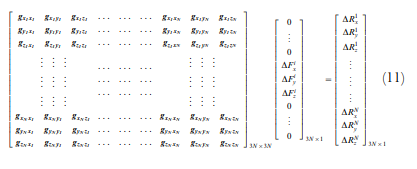

### Sparse Solution Optimization
Optimization utilizing the calculate (`initial_inv_hessian.dat`) and (`diffE.dat`).

Loading input files: initial_inv_hessian.dat and diffE.dat...
Running Practical Algorithm for K=1 to K=3...
--- Phase 1: Enumeration (k=1 to 2) ---
Using the ENUMERATION approach with k= 1
k=1


/var/folders/t2/3k7jg41d3971xn4gxyv_vl4m0000gn/T/ipykernel_6212/3547208948.py:132: RuntimeWarning: divide by zero encountered in matmul
  return linalg.solve(matmul(C[idx, :], C[:, idx]), matmul(C[idx, :], R))
/var/folders/t2/3k7jg41d3971xn4gxyv_vl4m0000gn/T/ipykernel_6212/3547208948.py:132: RuntimeWarning: overflow encountered in matmul
  return linalg.solve(matmul(C[idx, :], C[:, idx]), matmul(C[idx, :], R))
/var/folders/t2/3k7jg41d3971xn4gxyv_vl4m0000gn/T/ipykernel_6212/3547208948.py:132: RuntimeWarning: invalid value encountered in matmul
  return linalg.solve(matmul(C[idx, :], C[:, idx]), matmul(C[idx, :], R))


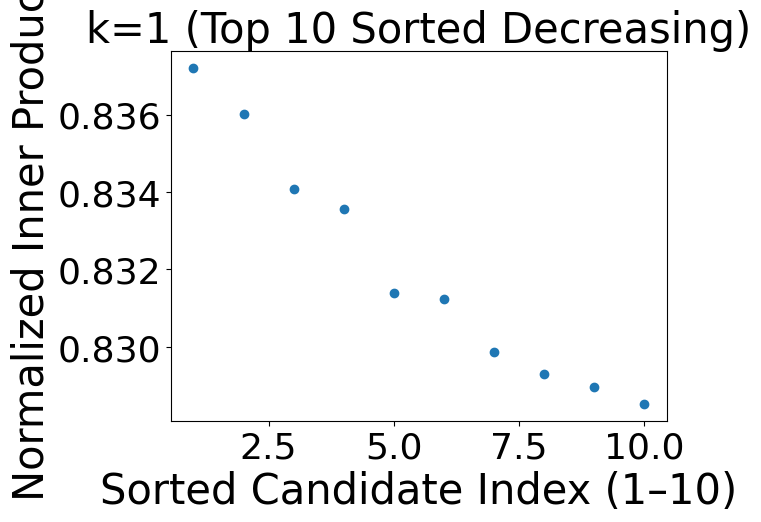

Time Elapsed in seconds: 0.015340089797973633
Best solution number 1
Value: 0.8372059115936378
Residue Indices (starting from 1): [230]
-109.87610289788822,-149.27637476163636,138.99584819187456

Best solution number 2
Value: 0.8360262862013574
Residue Indices (starting from 1): [190]
104.35235983177111,188.32357146056756,-32.41379777987525

Best solution number 3
Value: 0.8340823688761017
Residue Indices (starting from 1): [175]
29.719157203405324,46.986846780548206,-24.7411278743819

Best solution number 4
Value: 0.8335531226215124
Residue Indices (starting from 1): [191]
99.44161573913637,114.33124109398655,-29.927883027053024

Best solution number 5
Value: 0.8313946157485571
Residue Indices (starting from 1): [229]
-95.36112735107812,-101.34699152012737,28.87970329219998

Best solution number 6
Value: 0.8312451662525653
Residue Indices (starting from 1): [266]
207.55778236719422,-189.38893163551958,1.1176504715242437

Best solution number 7
Value: 0.8298726308513915
Residue Indices

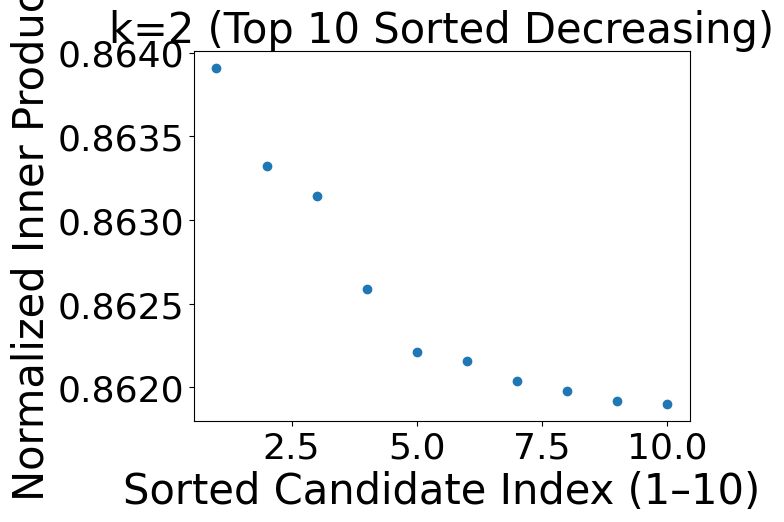

Time Elapsed in seconds: 2.8113930225372314
Best solution number 1
Value: 0.8639082124240169
Residue Indices (starting from 1): [211, 249]
213.8778006110805,146.26175793789255,84.897392781978
-8.465001699243581,-228.18199632318988,81.0469115725766

Best solution number 2
Value: 0.8633225362084288
Residue Indices (starting from 1): [211, 306]
192.4041866579391,165.09078984864846,16.72140614120649
17.65836353886712,101.61826346126455,-122.26066424372452

Best solution number 3
Value: 0.8631429316186137
Residue Indices (starting from 1): [209, 307]
142.1762275321089,129.55124534354877,11.091597716119296
16.069991522723,75.5563741466875,-155.2864119579968

Best solution number 4
Value: 0.8625902112316914
Residue Indices (starting from 1): [211, 305]
221.8197001335265,178.45307322630362,22.79146615775483
44.313862812268134,97.257286130819,-114.42395641808017

Best solution number 5
Value: 0.8622109730208446
Residue Indices (starting from 1): [210, 249]
197.83286661668876,93.53383064847604,8

In [12]:
with open("results.txt", "w") as f: f.write("")

try:
    from gurobipy import GRB, Model, quicksum
    HAS_GUROBI = True
except ImportError:
    HAS_GUROBI = False
    print("Gurobi not found. Optimization approach will be skipped.")

# Solution class to store the results
class Solution:
    def __init__(self, inner, subset, weights):
        self.inner = inner
        self.subset = subset
        self.weights = weights
    def __lt__(self, other):
        return self.inner < other.inner

# Print to file
def PrintToFile(message):
    print(message)
    with open("results.txt", "a") as f:
        f.write(message + "\n")
        f.flush()

# Print to console
def PrintConsole(bestSolutions, timeElapsed):
    lines = ["Time Elapsed in seconds: " + str(timeElapsed)]
    for i, sol in enumerate(bestSolutions, 1):
        lines.append(f"Best solution number {i}")
        lines.append("Value: " + str(sol.inner))
        lines.append("Residue Indices (starting from 1): " + str(sol.subset))
        for j in range(len(sol.subset)):
            w = sol.weights[3*j : 3*j+3]
            lines.append(f"{w[0]},{w[1]},{w[2]}")
        lines.append("")
    txt = "\n".join(lines)
    print(txt)
    with open("results.txt", "a") as f:
        f.write(txt + "\n")

# Normalized inner product
def NormalizedInnerProduct(v, R, Rn = None):
    if Rn is None:
        Rn = linalg.norm(R)
    return inner(v, R) / (linalg.norm(v) * Rn)

# Output model
def OutputModel(start, end, M, z, y, R, regularization):
    sol, subset, weights = zeros(len(R)), [], []
    for i in range(M):
        if z[i].x > 1e-3:
            subset.append(i + 1)
            for h in range(3):
                j = 3*i + h
                weights.append(y[j].x)
                sol += y[j].x * C[:, j]
    PrintConsole([Solution(NormalizedInnerProduct(sol, R), subset, weights)], end - start)

# Output model to file
def OutputModelToFile(start, end, M, z, y, R, regularization, filename=None):
    sol, maxIdx, weights = 0, [], []
    for i in range(M):
        if z[i].x > 1.0e-3:
            maxIdx.append(i + 1)
            w = []
            for h in range(3):
                j = 3 * i + h
                w.append(y[j].x)
                sol += y[j].x * C[:, j]
            weights.append(w)
    ni  = NormalizedInnerProduct(sol, R)
    PrintToFile("Maximum: " + str(ni))
    PrintToFile("Time Elapsed in seconds: " + str(end - start))
    PrintToFile("Maximizer Residue Indices (starting from 1): " + str(maxIdx))
    for w in weights:
        PrintToFile(",".join(map(str, w)))
    PrintToFile("")
    
    if filename:
        np.savetxt(filename, sol)
        print(f"Predicted vector saved to {filename}")
    
    return ni, end - start, maxIdx, weights

# Optimization approach (Uses Gurobi to solve the optimization problem with a given bigM value.)
def OptimizationApproach(C, R, K, bigM = 100, regularization = -1):
    if not HAS_GUROBI:
        print("Skipping OptimizationApproach: Gurobi not installed")
        return
    PrintToFile("Using the OPTIMIZATION approach with..")
    if regularization < 0:
        PrintToFile("k=" + str(K))
        PrintToFile("bigM=" + str(bigM))
    else:
        PrintToFile("Penalty=" + str(regularization))
    start = time.time()
    N, M = len(R), len(R) // 3
    model = Model('normalizedInnerProduct')
    model.setParam('OutputFlag', False) 
    
    # --- PERFORMANCE TUNING ---
    model.setParam('TimeLimit', 600)  # Set maximum runtime to 10 minutes
    model.setParam('MIPGap', 0.05)    # Set relative MIP optimality gap to 5%
    # --------------------------

    y = model.addVars(N, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
    u = model.addVars(N, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
    model.addConstrs(u[i] - quicksum(C[i, j] * y[j] for j in range(N)) == -R[i] for i in range(N))
    obj = quicksum(u[i] * u[i] for i in range(N))
    
    if regularization < 0:
        # Case 1: Subset selection using binary variables and big-M constraints
        z = model.addVars(M, vtype=GRB.BINARY)
        model.addConstrs(y[i] >= -bigM * z[i // 3] for i in range(N))
        model.addConstrs(y[i] <=  bigM * z[i // 3] for i in range(N))
        model.addConstr(z.sum() == K)
    else:
        # Case 2: L1 regularization (Lasso-like)
        z = model.addVars(M, lb = 0)
        model.addConstrs( y[i] <= z[i // 3] for i in range(N))
        model.addConstrs(-y[i] <= z[i // 3] for i in range(N))
        obj += regularization * z.sum()
        
    model.setObjective(obj, GRB.MINIMIZE)
    model.optimize()
    
    OutputModelToFile(start, time.time(), M, z, y, R, regularization)

# Least squares solution
def LeastSquaresSolution(C, R, idx):
    return linalg.solve(matmul(C[idx, :], C[:, idx]), matmul(C[idx, :], R))

# Enumeration approach (Exhaustively searches all combinations of K residues to find the best fit.)
def EnumerationApproach(C, R, K, best = 10):
    print("Using the ENUMERATION approach with k=", K)
    PrintToFile(f"k={K}")
    start = time.time()
    N, M = len(R), len(R) // 3
    bestS = [Solution(0, [], [])]*best
    Rn, inners = linalg.norm(R), []
    
    for subset in combinations(range(M), K):
        idx = [3*h + d for h in subset for d in range(3)]
        coeff = LeastSquaresSolution(C, R, idx)
        v = sum(coeff[i] * C[:, idx[i]] for i in range(3*K))
        val = NormalizedInnerProduct(v, R, Rn)
        inners.append(val)
        sol = Solution(val, [s+1 for s in subset], coeff)
        
        if heapq.nsmallest(1,bestS)[0].inner < sol.inner:
            heapq.heapreplace(bestS, sol)
            
    end = time.time()
    
    x = list(range(1, best+1))
    plt.scatter(x, sorted(inners, reverse=True)[:best])
    plt.title(f"k={K} (Top {best} Sorted Decreasing)", fontsize = 30)
    plt.xlabel("Sorted Candidate Index (1–10)", fontsize = 30)
    plt.ylabel("Normalized Inner Product", fontsize = 30)
    ax = plt.gca()
    ticks = ax.get_yticks()
    if len(ticks) > 1:
        dp = max(0, int(-floor(log10(abs(ticks[1]-ticks[0])))))
        ax.yaxis.set_major_formatter(FormatStrFormatter(f'%.{dp}f'))
    ax.tick_params(axis='x', labelsize = 26)
    ax.tick_params(axis='y', labelsize = 26)
    plt.show()
    
    PrintConsole(heapq.nlargest(best, bestS), end - start)
    
    best_sol = heapq.nlargest(1, bestS)[0]
    best_subset_0based = [s-1 for s in best_sol.subset]
    idx = [3*h + d for h in best_subset_0based for d in range(3)]
    v_best = sum(best_sol.weights[i] * C[:, idx[i]] for i in range(len(best_sol.weights)))
    return ceil(max(abs(sol.weights).max() for sol in heapq.nlargest(best, bestS)))

#   Practical algorithm (Hybrid Approach:
#   - Uses Enumeration for k = 1 to Kstar (Fast, exact, calculates bigM).
#   - Uses Gurobi Optimization for k = Kstar+1 to Kmax (Scalable).)
def PracticalAlgorithm(C, R, Kmin, Kmax, Kstar = 2):
    bigM = 0
    print(f"--- Phase 1: Enumeration (k=1 to {Kstar}) ---")
    
    # Step 1: Run Enumeration up to Kstar (calculates bigM and solves small problems)
    for k in range(1, Kstar + 1):
        current_M = EnumerationApproach(C, R, k)
        bigM = max(bigM, current_M)

    print(f"\n*** Determined bigM = {bigM} from Enumeration ***\n")
    
    # Step 2: Run Optimization for larger K
    # Start from max(Kmin, Kstar + 1) to avoid re-doing small k with Gurobi
    start_opt = max(Kmin, Kstar + 1)
    
    if start_opt <= Kmax:
        print(f"--- Phase 2: Gurobi Optimization (k={start_opt} to {Kmax}) ---")
        if HAS_GUROBI:
            for k in range(start_opt, Kmax + 1):
                OptimizationApproach(C, R, k, bigM)
        else:
            print("Skipping OptimizationApproach steps as Gurobi is not available.")
    else:
        print(f"No Gurobi Optimization needed (User requested Kmax={Kmax} <= Kstar={Kstar}).")

# Load input files
hessian_file = "initial_inv_hessian.dat"
diff_file = "diffE.dat"


if os.path.exists(hessian_file) and os.path.exists(diff_file):
    print(f"Loading input files: {hessian_file} and {diff_file}...")
    C = np.loadtxt(hessian_file)
    R = np.loadtxt(diff_file)
    
    print(f"Running Practical Algorithm for K={Kmin} to K={Kmax}...")
    PracticalAlgorithm(C, R, Kmin, Kmax)
else:
    print(f"Error: Required files '{hessian_file}' or '{diff_file}' not found.")
    print("Please execute either Option 1 (PDB Analysis) or Option 2 (DCD Analysis) to generate these files.")

### Vector Processing
Generates .bild file for visualization in ChimeraX.

In [13]:
def calculate_final_coords_and_generate_bild(initial_coords, vectors, output_file, scale_factor=20, arrow_radius=0.2, sphere_radius=1.0):
    initial_coords = np.array(initial_coords)
    vectors = np.array(vectors)
    scaled_vectors = vectors / scale_factor
    final_coords = initial_coords + scaled_vectors

    bild_content = []
    for i, (start, end, vector, scaled_vector) in enumerate(zip(initial_coords, final_coords, vectors, scaled_vectors)):
        bild_content.append(f"# Element {i + 1}\n")
        # 1. Draw a sphere at the starting coordinate
        bild_content.append(".color blue\n")
        bild_content.append(f".sphere {start[0]:.3f} {start[1]:.3f} {start[2]:.3f} {sphere_radius}\n")
        
        # 2. Draw an arrow from start to end coordinate
        bild_content.append(".color red\n")
        bild_content.append(
            f".arrow {start[0]:.3f} {start[1]:.3f} {start[2]:.3f} "
            f"{end[0]:.3f} {end[1]:.3f} {end[2]:.3f} {arrow_radius}\n"
        )
    
    with open(output_file, 'w') as file:
        file.writelines(bild_content)

if os.path.exists(INITIAL_PDB):
    pdb = parsePDB(INITIAL_PDB)
    calphas = pdb.select("calpha")
    all_coords = calphas.getCoords()
    all_resnums = calphas.getResnums()
    all_resnames = calphas.getResnames()
else:
    raise FileNotFoundError("initial.pdb not found.")

output_dir = "bild_files"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")
else:
    print(f"Using directory: {output_dir}")

results_file = "results.txt"
if os.path.exists(results_file):
    print(f"Parsing {results_file}...")
    with open(results_file, 'r') as f:
        content = f.read()

    dataset_blocks = [b for b in content.split("Time Elapsed") if "Best solution number" in b or "Maximizer Residue Indices" in b]

    for block in dataset_blocks:
        k = -1
        if "Maximizer Residue Indices" in block:
            sol_chunks = ["1\n" + block]
        else:
            sol_chunks = block.split("Best solution number")
        for chunk in sol_chunks:
            if not chunk.strip(): continue
            lines = chunk.strip().split('\n')
            for line in lines:
                if "Residue Indices" in line:
                    try:
                        part = line.split(':')[1].strip().replace('[', '').replace(']', '')
                        if part:
                            idxs = [int(x.strip()) for x in part.split(',')]
                            k = len(idxs)
                    except:
                        pass
                    break
            if k != -1: break
        
        if k == -1: continue
        
        #         if 'Kmax' in locals() and k > Kmax:
        # continue
            
        print(f"\n--- Processing K={k} ---")
        
        for chunk in sol_chunks:
            if not chunk.strip(): continue
            lines = chunk.strip().split('\n')
            
            try:
                rank = int(lines[0].strip())
            except ValueError:
                continue
            
            if rank > 10: continue

            indices = []
            vectors = []
            w_start = -1

            for i, line in enumerate(lines):
                if "Residue Indices" in line:
                    part = line.split(':')[1].strip().replace('[', '').replace(']', '')
                    if part:
                        indices = [int(x.strip()) for x in part.split(',')]
                    w_start = i + 1
                    break
            
            if w_start != -1 and indices:
                for i in range(len(indices)):
                    if w_start + i < len(lines):
                        w_line = lines[w_start + i].strip()
                        if w_line: 
                            try:
                                vec = [float(x) for x in w_line.split(',')]
                                if len(vec) == 3:
                                    vectors.append(vec)
                            except ValueError:
                                pass
                
                if len(vectors) == len(indices):
                    selected_coords = []
                    residue_info_str = []
                    
                    for idx in indices:
                        if 1 <= idx <= len(all_coords):
                            selected_coords.append(all_coords[idx-1])
                            res_str = f"{all_resnames[idx-1]}{all_resnums[idx-1]}"
                            residue_info_str.append(res_str)
                        else:
                            residue_info_str.append(f"UNK{idx}")
                    
                    print(f"Rank {rank}: Indices={indices} ({', '.join(residue_info_str)})")
                    for v_idx, vec in enumerate(vectors):
                        print(f"   Vector {v_idx+1}: [{vec[0]:.2f}, {vec[1]:.2f}, {vec[2]:.2f}]")

                    if len(selected_coords) == len(vectors):
                        outfile = os.path.join(output_dir, f"perturbation_vector_k{k}_rank{rank}.bild")
                        calculate_final_coords_and_generate_bild(selected_coords, vectors, outfile, sphere_radius=1.5)
                        print(f"   Saved: {outfile}")
else:
    print("results.txt not found.")

@> 32955 atoms and 1 coordinate set(s) were parsed in 0.12s.


Using directory: bild_files
Parsing results.txt...

--- Processing K=1 ---
Rank 1: Indices=[230] (ALA230)
   Vector 1: [-109.88, -149.28, 139.00]
   Saved: bild_files/perturbation_vector_k1_rank1.bild
Rank 2: Indices=[190] (ALA190)
   Vector 1: [104.35, 188.32, -32.41]
   Saved: bild_files/perturbation_vector_k1_rank2.bild
Rank 3: Indices=[175] (ASN175)
   Vector 1: [29.72, 46.99, -24.74]
   Saved: bild_files/perturbation_vector_k1_rank3.bild
Rank 4: Indices=[191] (LEU191)
   Vector 1: [99.44, 114.33, -29.93]
   Saved: bild_files/perturbation_vector_k1_rank4.bild
Rank 5: Indices=[229] (GLY229)
   Vector 1: [-95.36, -101.35, 28.88]
   Saved: bild_files/perturbation_vector_k1_rank5.bild
Rank 6: Indices=[266] (PRO266)
   Vector 1: [207.56, -189.39, 1.12]
   Saved: bild_files/perturbation_vector_k1_rank6.bild
Rank 7: Indices=[289] (SER289)
   Vector 1: [-62.44, 22.59, -36.74]
   Saved: bild_files/perturbation_vector_k1_rank7.bild
Rank 8: Indices=[192] (ILE192)
   Vector 1: [28.14, 123.66, 